# Oil & Gas Production Forecasting — Prophet Model

This notebook applies Facebook Prophet to forecast gas production.  
We optimize model hyperparameters and save standardized results for later comparison.


**NOTES:**

* Prophet + ARIMA only use period (ds) and MBBL/D (y), because these models:

    - are designed for univariate forecasting
    - internally model seasonality, trends, changepoints
    - don’t take exogenous variables in standard use

**Prophet**

**Additive Model:** Prophet assumes time series are made up of several components added together:
- Trend: The overall direction of the data over time (e.g., increasing sales).
- Seasonality: Regular repeating patterns (e.g., weekly, yearly cycles).
- Holidays/Events: Special spikes or dips due to known events.

### 1.Imports & Dataset

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import optuna

sns.set(style="whitegrid")

# Load feature dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df_prophet = df[['period', 'MBBL/D']].rename(columns={'period': 'ds', 'MBBL/D': 'y'})

### 2.Train-test split

In [3]:
train_size = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

### 3.Bayesian hyperparameter tuning

In [4]:
def objective(trial):
    """Objective function for Optuna to optimize hyperparameters."""
    
    model = Prophet(
        changepoint_prior_scale=trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        seasonality_prior_scale=trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        holidays_prior_scale=trial.suggest_float('holidays_prior_scale', 0.01, 10),
        yearly_seasonality=True
    )
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = model.predict(future)
    y_pred = forecast.iloc[-len(test):]['yhat'].values
    y_true = test['y'].values
    return mean_absolute_error(y_true, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-05-17 13:00:45,117] A new study created in memory with name: no-name-2c578811-11e4-4bd2-bfa7-93082f8dd28b
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-17 13:00:45,784] Trial 0 finished with value: 429.17375682944834 and parameters: {'changepoint_prior_scale': 0.24371792024585745, 'seasonality_prior_scale': 7.4985583341642945, 'holidays_prior_scale': 0.87730869328315}. Best is trial 0 with value: 429.17375682944834.
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-17 13:00:46,087] Trial 1 finished with value: 429.18621886533595 and parameters: {'changepoint_prior_scale': 0.2835111954795298, 'seasonality_prior_scale': 5.67310360079304, 'holidays_prior_scale': 6.958016732523401}. Best is trial 0 with value: 429.17375682944834.
13:00:46 - cmdstanpy - INFO - Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] done pr

In [5]:
best_params = study.best_params
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'changepoint_prior_scale': 0.4729852656548956, 'seasonality_prior_scale': 4.409672228892176, 'holidays_prior_scale': 2.9719100077466294}


In [33]:
# Save the best parameters to a JSON file
with open('../models/prophet_best_params.json', 'w') as f:
    json.dump(best_params, f)

### 4.Train final model

In [34]:
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    yearly_seasonality=True
)
model.fit(train)

18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing


### 5.Forecasting

In [35]:
future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)

# Extract predictions
y_pred = forecast.iloc[-len(test):]['yhat'].values
y_true = test['y'].values

#### 6.Standardized evaluation metrics

In [40]:
metrics = {
    "MAE": mean_absolute_error(y_true, y_pred),
    "MSE": mean_squared_error(y_true, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "R2": r2_score(y_true, y_pred),
    "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
}
print(metrics)


{'MAE': 420.3663831156773, 'MSE': 282848.5395686443, 'RMSE': np.float64(531.8350680132369), 'R2': 0.841749805294623, 'MAPE': np.float64(5.649537188458609)}


In [41]:
# Save the model and the results.
results = {"model": "PROPHET", "metrics": metrics}
with open('../results/prophet_results.json', 'w') as f:
    json.dump(results, f)


# Save predictions and metrics.
pd.DataFrame({"ds": test['ds'], "y_true": y_true, "y_pred": y_pred}).to_csv(
    "../results/prophet_predictions.csv", index=False
)

### 7. Plot predictions

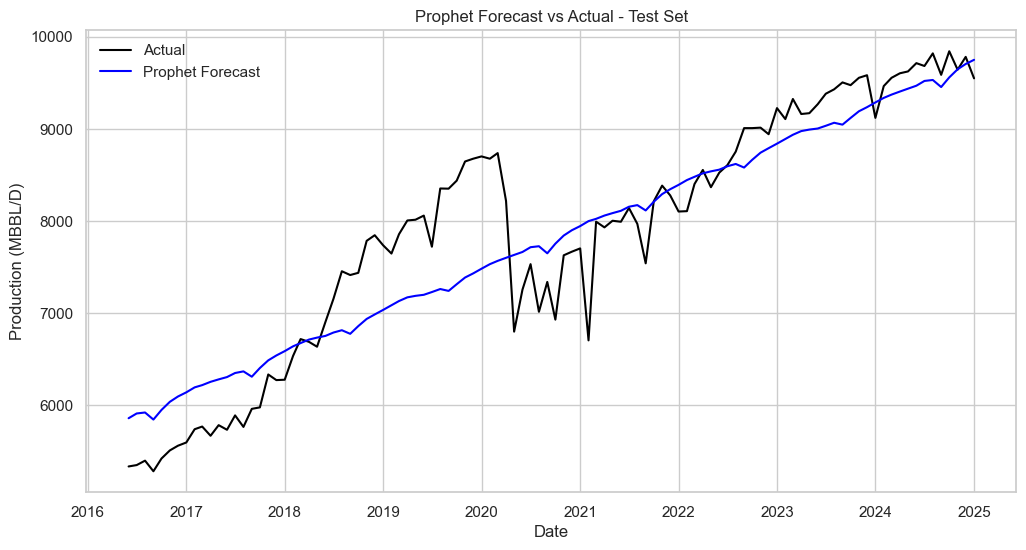

In [39]:
plt.figure(figsize=(12,6))
plt.plot(test['ds'], y_true, label='Actual', color='black')
plt.plot(test['ds'], y_pred, label='Prophet Forecast', color='blue')
plt.title("Prophet Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

We used Bayesian hyperparameter optimization (Optuna) to tune Prophet model hyperparameters.
Evaluation was done on a holdout test set (20% of data).
Results (metrics + predictions) were stored in standardized files for later comparison with ARIMA and LSTM models.
This ensures full reproducibility and fair comparison across approaches in 07_model_comparison.ipynb.